# Task
Сделать базовый вариант бинарной классификации, от которого можно отталкиваться в дальнейшем

# Import modules

In [34]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [35]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [36]:
df = data.copy()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [38]:
df.index

DatetimeIndex(['2017-09-01 00:00:00', '2017-09-01 01:00:00',
               '2017-09-01 02:00:00', '2017-09-01 03:00:00',
               '2017-09-01 04:00:00', '2017-09-01 05:00:00',
               '2017-09-01 06:00:00', '2017-09-01 07:00:00',
               '2017-09-01 08:00:00', '2017-09-01 09:00:00',
               ...
               '2023-04-23 14:00:00', '2023-04-23 15:00:00',
               '2023-04-23 16:00:00', '2023-04-23 17:00:00',
               '2023-04-23 18:00:00', '2023-04-23 19:00:00',
               '2023-04-23 20:00:00', '2023-04-23 21:00:00',
               '2023-04-23 22:00:00', '2023-04-23 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=49337, freq=None)

In [39]:
# df = df.asfreq('H')
# df = df.asfreq('H') # этот вариант сработает, но на месте пропусков появятся NaN записи

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [43]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

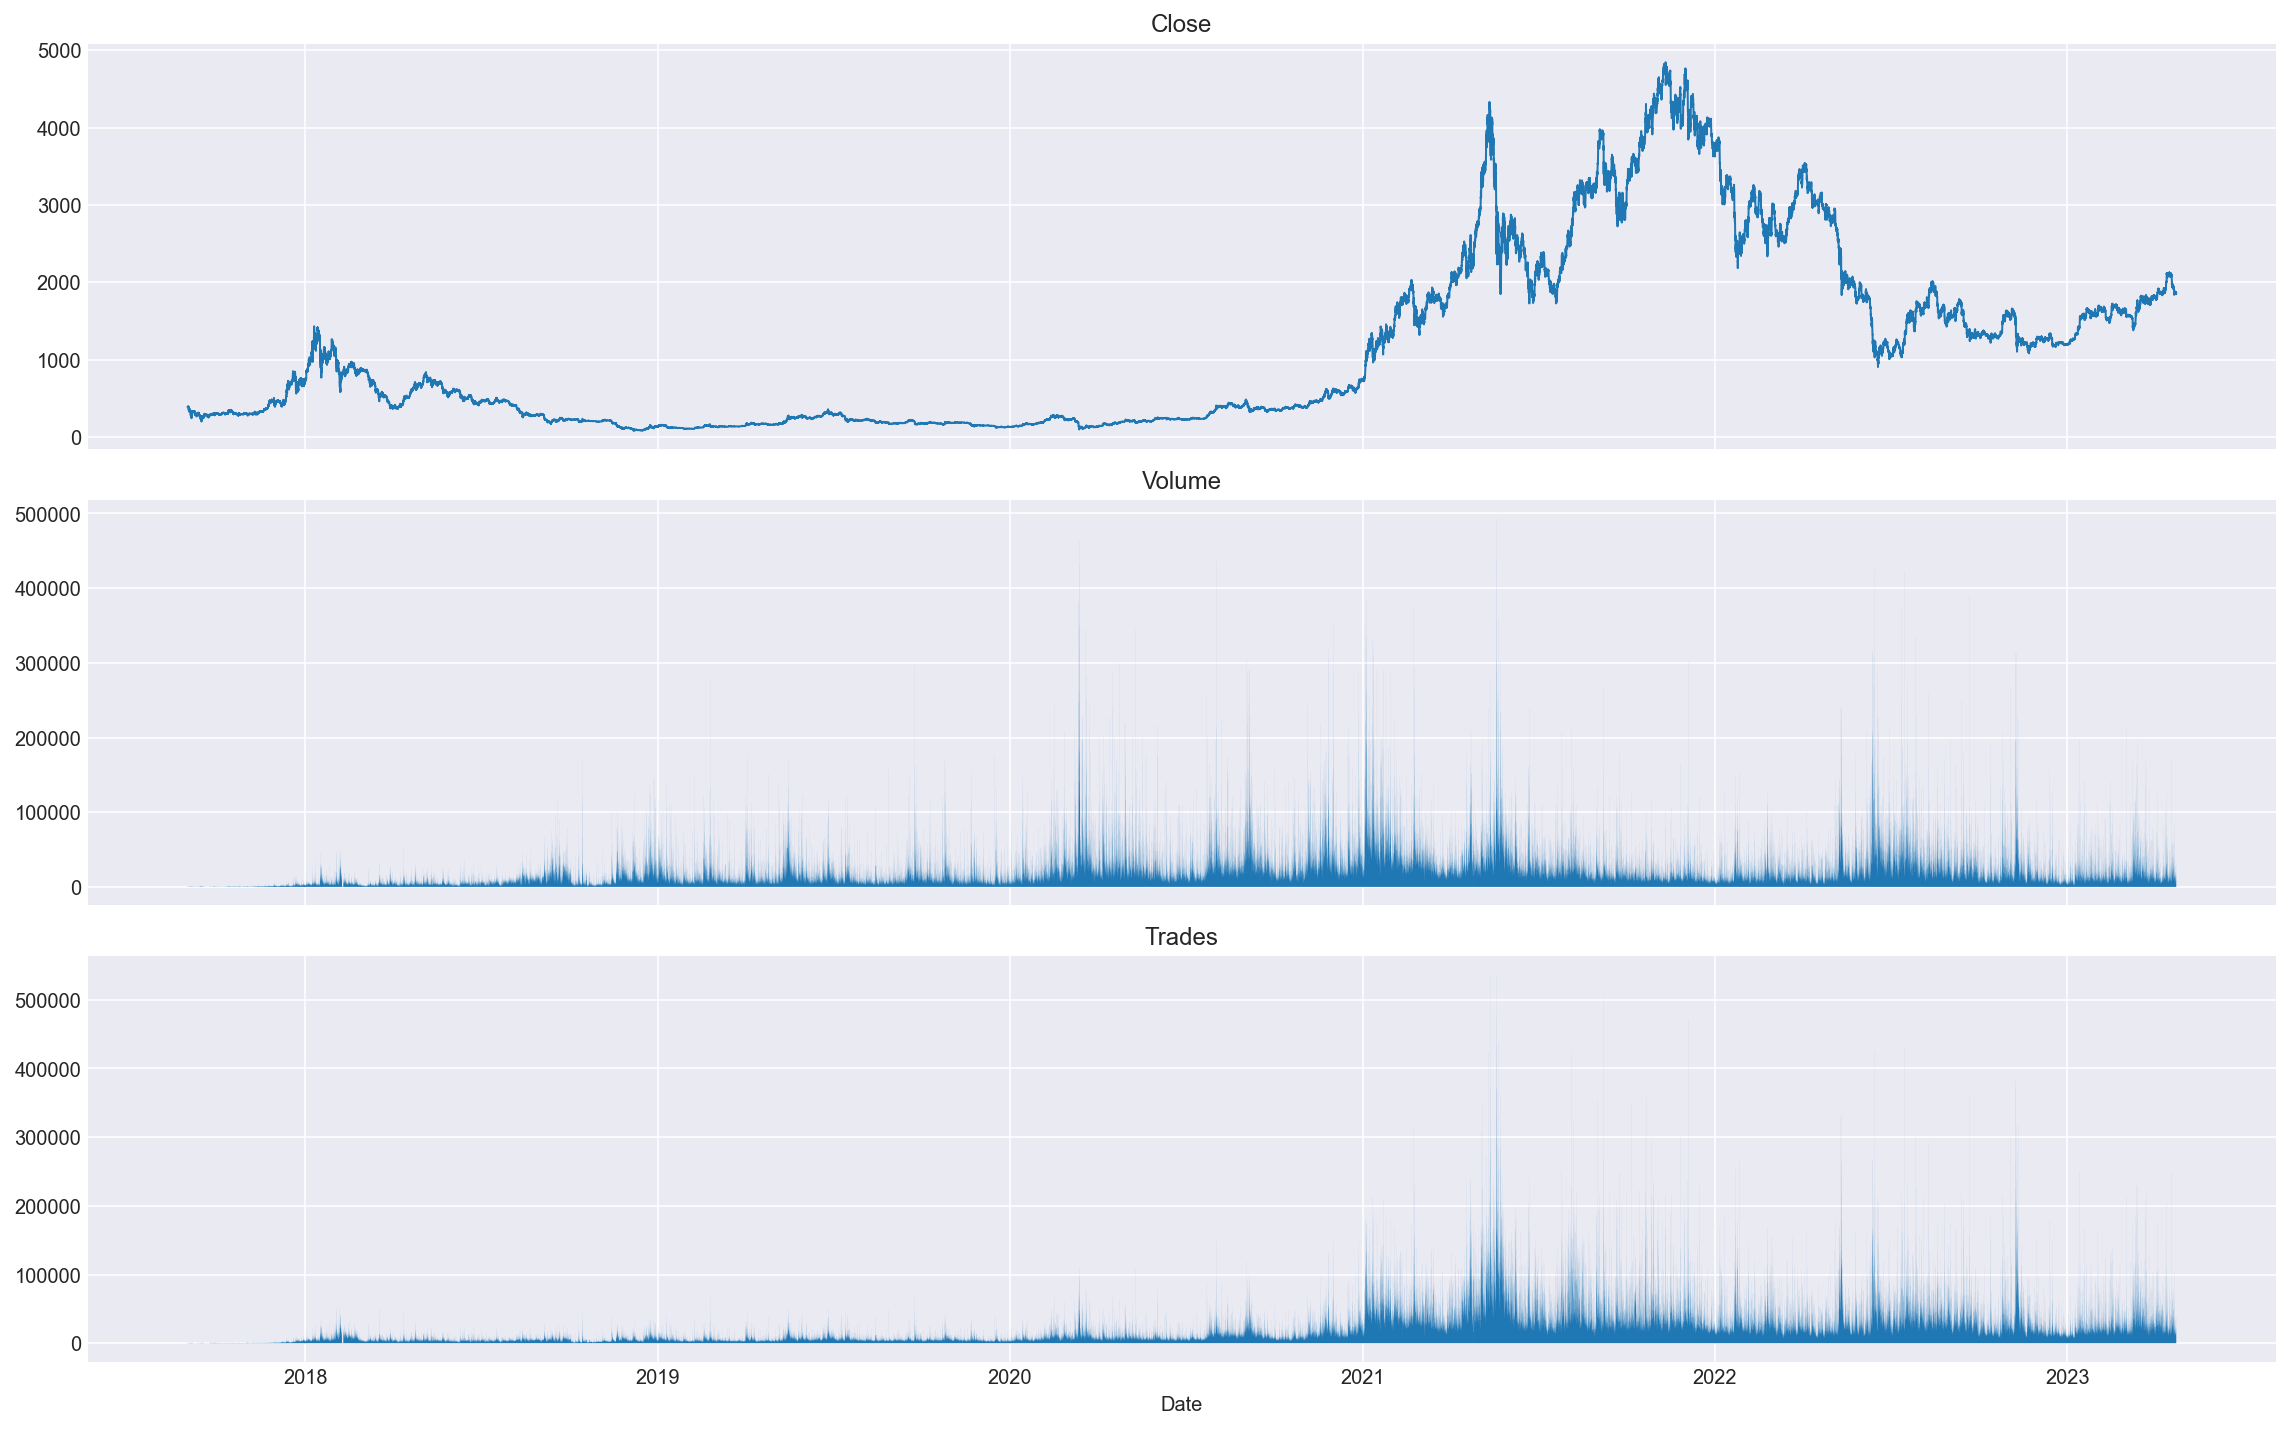

In [68]:
# If need to plot not all data
# df_to_plot = df[df.index >= '2023-04-20']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Volume'].to_numpy()
_2 = df_to_plot['Trades'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Volume')

ax[2].fill_between(ind, _2, step='pre')
ax[2].set_title('Trades')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [61]:
df.tail()

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.1829,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.4755,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.6133,13824
2023-04-23 22:00:00,1854.67,1868.16,1848.00,1861.72,15836.4843,21852
2023-04-23 23:00:00,1861.72,1865.60,1859.17,1862.00,8767.1279,12371


### Провека всех признаков исходного ряда на стационарность

In [31]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [33]:
for col_name, col_data in df.items():
    print("Column Name : ", col_name)
    adf(col_data.values)
    print()

Column Name :  Open
Test-Statistic: -1.4966210042383448
P-Value: 0.5351822126304921
Non-Stationary

Column Name :  High
Test-Statistic: -1.4831154723390136
P-Value: 0.5418467263622183
Non-Stationary

Column Name :  Low
Test-Statistic: -1.4974367518330751
P-Value: 0.5347789578907209
Non-Stationary

Column Name :  Close
Test-Statistic: -1.498866116461962
P-Value: 0.5340721801256405
Non-Stationary

Column Name :  Volume
Test-Statistic: -11.744751447199127
P-Value: 1.2491780220513623e-21
Stationary!

Column Name :  Trades
Test-Statistic: -8.452786005432719
P-Value: 1.645135614083133e-13
Stationary!



# Feature Enginiring
Логарифмирую все признаки

In [25]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

In [26]:
df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [27]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,
2017-09-01 00:00:00,5.952698,5.962911,5.952698,5.962911,5.093614,4.875197
2017-09-01 01:00:00,5.962782,5.976503,5.959793,5.969653,5.516366,5.568345
2017-09-01 02:00:00,5.973504,5.977340,5.964761,5.968401,5.292443,5.416100
2017-09-01 03:00:00,5.970496,5.974140,5.968349,5.968349,4.952732,4.927254
2017-09-01 04:00:00,5.972919,5.977036,5.960077,5.966993,4.910144,4.852030
...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [28]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [29]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

# Target Category Feature 
Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4


In [30]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor

По данным переменным можно создавать сетку для поиска рабочих вариантов

In [31]:
df['Label_long'] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

In [32]:
def class_distribution(df, col):
    """ Метод для визуализации значений распределения для заданного категориального признака

    Args:
        df (_type_): датафрейм для анализа
        col (_type_): имя признака в датафрейме анализ по которому вывести

    Returns:
        _type_: _description_
    """
    class_df = pd.DataFrame({'%': (df[col].value_counts(True) * 100).round(2), 'Count': df[col].value_counts()})
    class_df.index.name = 'Class'
    class_df.sort_index(ascending=False, inplace=True)
    display(class_df)
    
    sns.countplot(data=df, x=col)
    plt.show()

,%,Count
Class,,
1,9.42,4650
0,90.58,44687


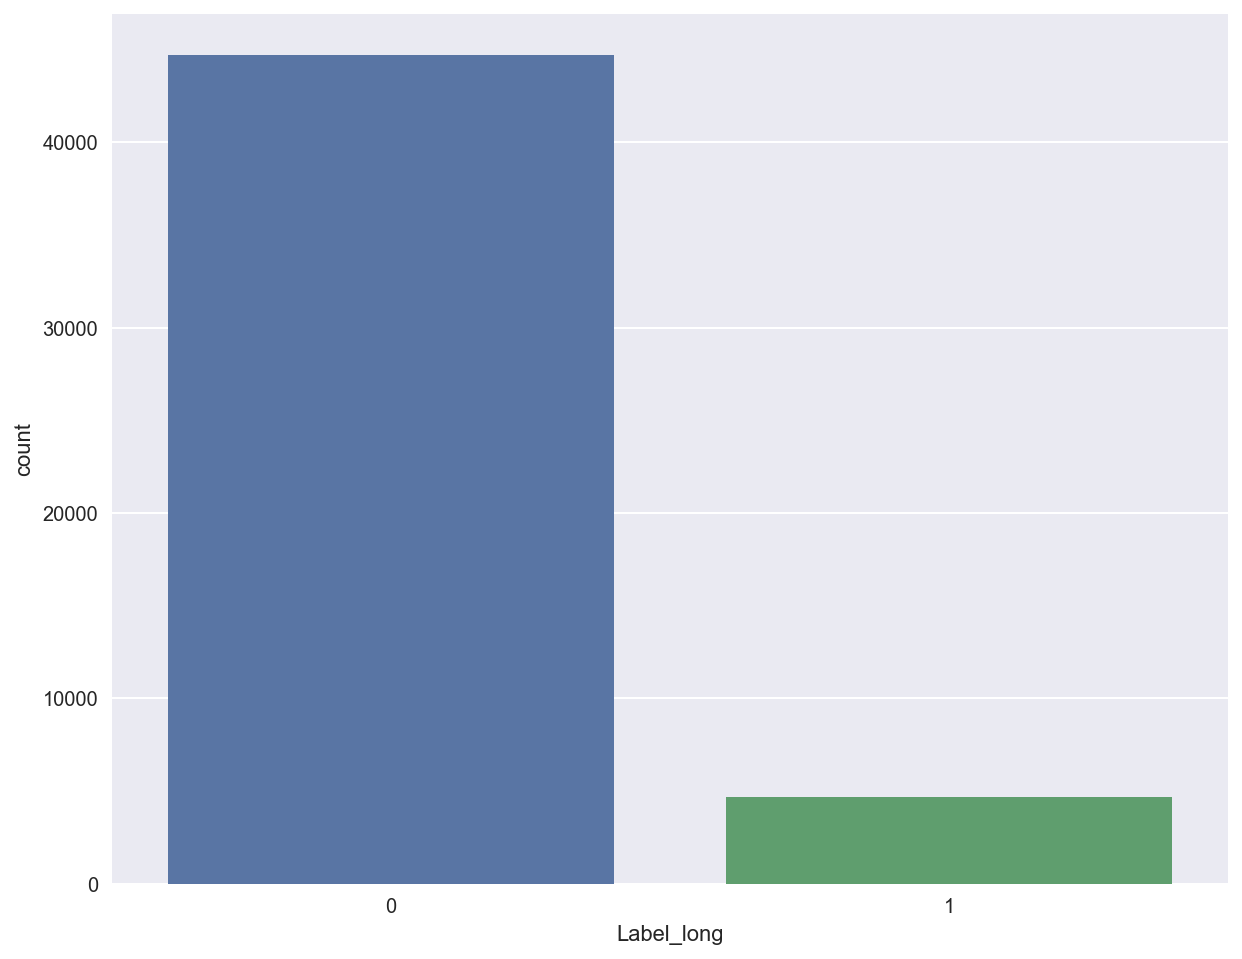

In [33]:
class_distribution(df, 'Label_long')

In [34]:
df

,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log,Low_Shad_log,High_Shad_log,Log_Return,Label_long
Datetime,,,,,,,,,,
2017-09-01 00:00:00,5.952698,5.962911,5.952698,5.962911,5.093614,4.875197,0.000000,0.010213,0.010213,1
2017-09-01 01:00:00,5.962782,5.976503,5.959793,5.969653,5.516366,5.568345,0.002989,0.013721,0.006871,0
2017-09-01 02:00:00,5.973504,5.977340,5.964761,5.968401,5.292443,5.416100,0.008743,0.003836,-0.005104,0
2017-09-01 03:00:00,5.970496,5.974140,5.968349,5.968349,4.952732,4.927254,0.002147,0.003644,-0.002147,0
2017-09-01 04:00:00,5.972919,5.977036,5.960077,5.966993,4.910144,4.852030,0.012842,0.004117,-0.005926,0
...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668,0.000997,0.003022,-0.000146,0
2023-04-23 20:00:00,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345,0.004592,0.003142,0.001299,0
2023-04-23 21:00:00,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161,0.000698,0.005631,0.003121,0
